In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from autoviz.AutoViz_Class import AutoViz_Class
%matplotlib inline

In [15]:
# read csv and apply datetime to sample date column
df = pd.read_csv('Boonsong Lekagul waterways readings.csv')
df['sample date'] = pd.to_datetime(df['sample date'])


# create new feature: contamination_factor that has 1 representative contamination measure for the following: 
# water oxygen content, hardness, micro-organism, insecticide,o rganic solvent, hard metal & optimum
df['contamination_factors'] = np.where((df['measure'] == 'Chemical Oxygen Demand (Cr)'),'Water oxygen content',
                              np.where((df['measure'] == 'Total hardness'),'Hardness',
                                  np.where((df['measure'] == 'Total coliforms'),'Micro-organisms',
                                    np.where((df['measure'] == 'p,p-DDT') ,'Insecticides',
                                      np.where((df['measure'] == 'Methylosmoline'),'Organic Solvents',  
                                        np.where((df['measure'] == 'Arsenic'),'Hard Metals',      
                                          np.where((df['measure'] == 'Water temperature'),'Optimum_measures','Others')))))))

In [16]:
df.isna().sum()  # no missing values

id                       0
value                    0
location                 0
sample date              0
measure                  0
contamination_factors    0
dtype: int64

In [17]:
df.head(5)

,id,value,location,sample date,measure,contamination_factors
0,2221,2.00,Boonsri,1998-01-11,Water temperature,Optimum_measures
1,2223,9.10,Boonsri,1998-01-11,Dissolved oxygen,Others
2,2227,0.33,Boonsri,1998-01-11,Ammonium,Others
3,2228,0.01,Boonsri,1998-01-11,Nitrites,Others
4,2229,1.47,Boonsri,1998-01-11,Nitrates,Others


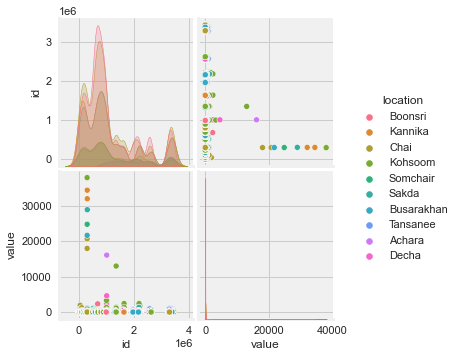

In [18]:
# EDA: Step 1
# dataframe pairplot
sns.pairplot(df, hue='location', diag_kind='kde')
plt.show()

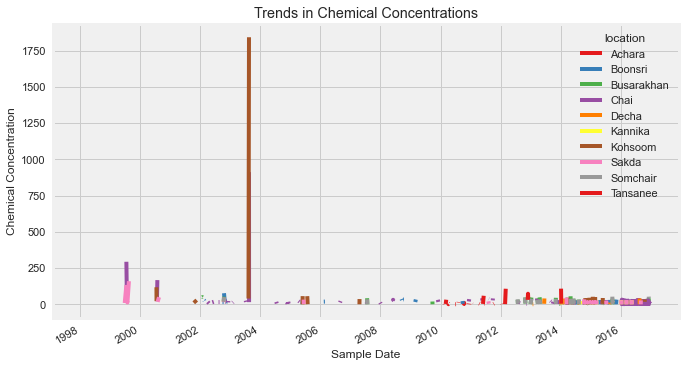

In [19]:
# group data by date
grouped_data = df.groupby(['sample date', 'location'])['value'].mean().reset_index()

# pivot the data
time_series_data = grouped_data.pivot(index='sample date', columns='location', values='value')

# plot the time series data
plt.figure(figsize=(10, 6))
time_series_data.plot(ax=plt.gca())
plt.xlabel('Sample Date')
plt.ylabel('Chemical Concentration')
plt.title('Trends in Chemical Concentrations')
plt.grid(True)
plt.show()

Shape of your Data Set loaded: (136824, 6)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
    Number of Numeric Columns =  1
    Number of Integer-Categorical Columns =  0
    Number of String-Categorical Columns =  3
    Number of Factor-Categorical Columns =  0
    Number of String-Boolean Columns =  0
    Number of Numeric-Boolean Columns =  0
    Number of Discrete String Columns =  0
    Number of NLP String Columns =  0
    Number of Date Time Columns =  1
    Number of ID Columns =  1
    Number of Columns to Delete =  0
    6 Predictors classified...
        1 variables removed since they were ID or low-information variables


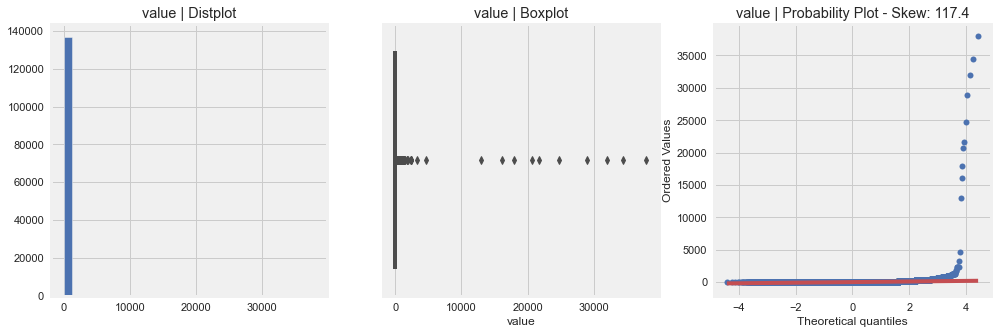

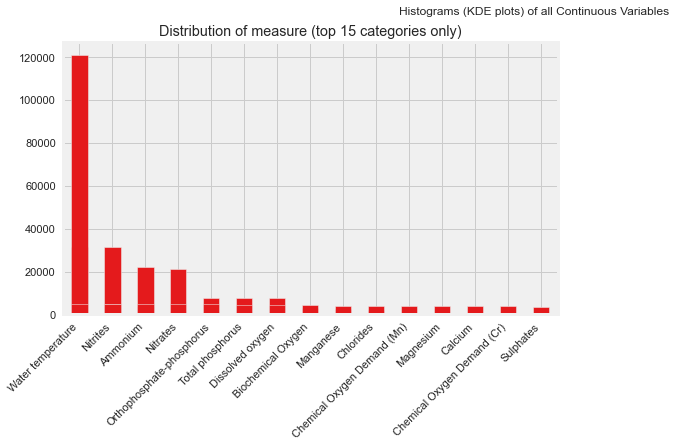

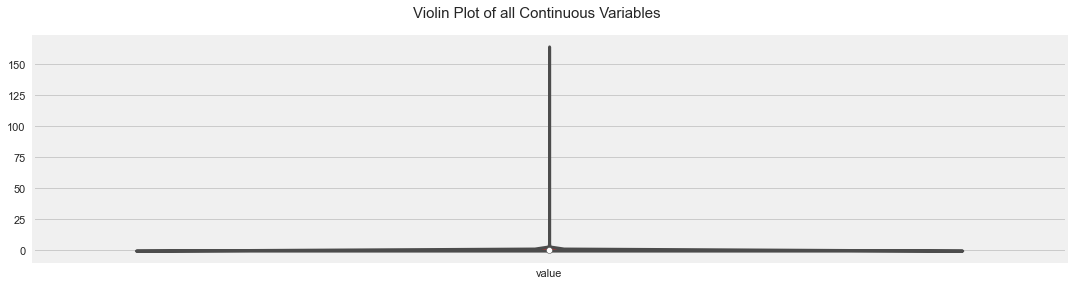

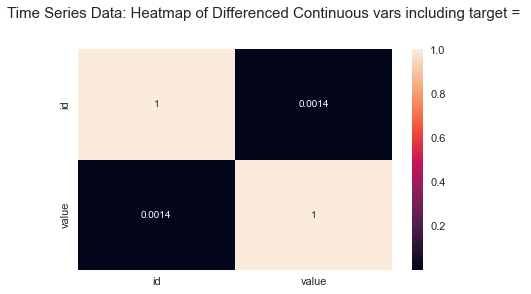

<Figure size 1080x0 with 0 Axes>

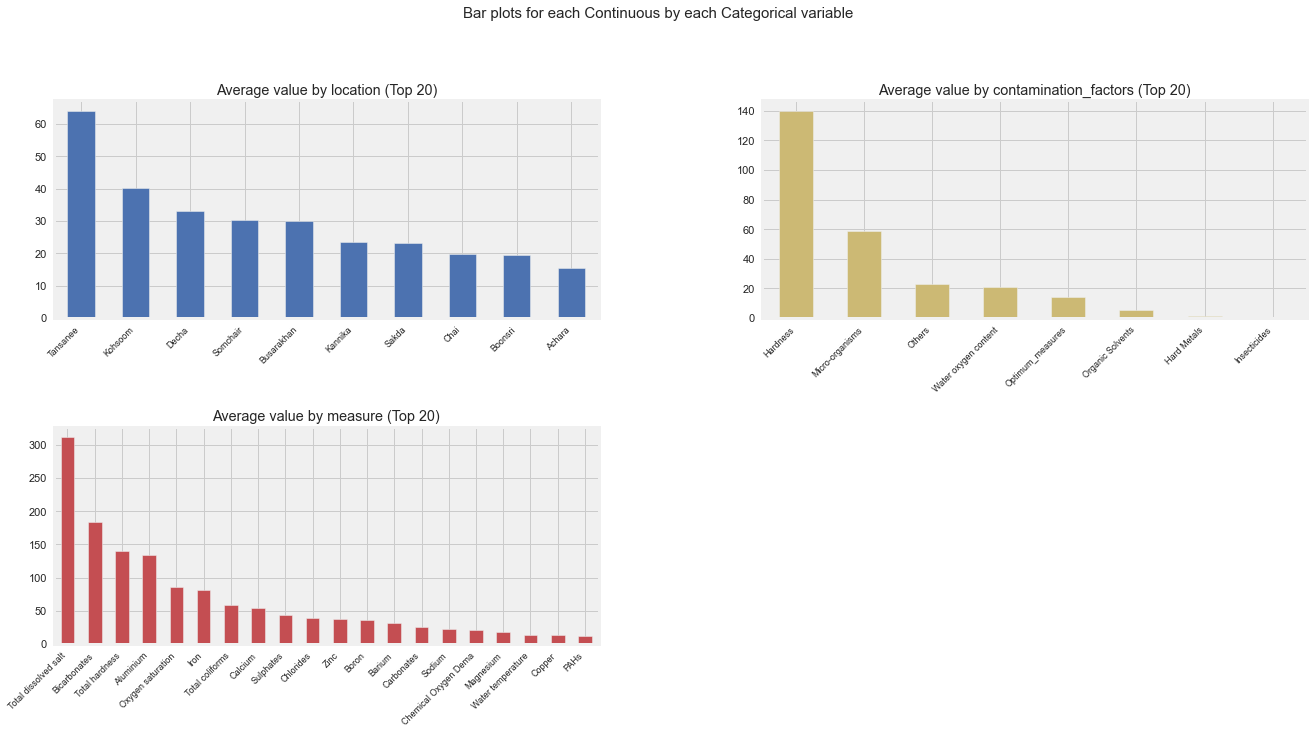

All Plots done
Time to run AutoViz = 3 seconds 

 ###################### AUTO VISUALIZATION Completed ########################


In [20]:
AV = AutoViz_Class()
filename = ""
sep = ","
dft = AV.AutoViz(
    filename,
    sep = sep,
    depVar = "",
    dfte = df,
    header = 0,
    verbose = 0,
    lowess = False,
    chart_format = "png"
)

In [21]:
# apply label encoder to categorical columns
label_encoder = LabelEncoder()
df_encoded = df.copy()
df_encoded['contamination_factors'] = label_encoder.fit_transform(df_encoded['contamination_factors'])
df_encoded['location'] = label_encoder.fit_transform(df_encoded['location'])
df_encoded['measure'] = label_encoder.fit_transform(df_encoded['measure'])

# drop sample date
df_anomaly = df_encoded.drop(['sample date'], axis=1)

# separate features and target
X = df_anomaly.drop(['value', 'id'], axis=1)  # features
y = df_anomaly['value']  # target

# get dummy variables for categorical columns
X_encoded = pd.get_dummies(X, columns=['location', 'measure', 'contamination_factors'])

# combine one-hot encoded columns with numeric columns
numeric_columns = X.select_dtypes(include='number').columns
X_combined = pd.concat([X_encoded, X[numeric_columns]], axis=1)

In [22]:
# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.33, random_state=99)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(91672, 127)
(45152, 127)
(91672,)
(45152,)


In [23]:
# apply one-hot encoding and standard scaling on the modified training data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns)
    ],
    remainder='passthrough'  # Keep the non-transformed columns as is
)

# fit and transform the preprocessor on the modified training data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

Proportion of anomalies: 0.009947085306671344
Accuracy of anomaly detection: 0.13842600713325148


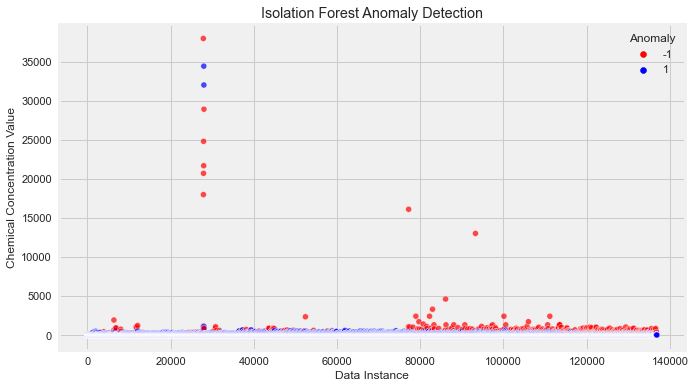

In [24]:
# initialize and fit the Isolation Forest model
isolation_forest = IsolationForest(contamination=0.01, random_state=99)
isolation_forest.fit(df_anomaly)

# predict anomalies (outliers)
anomalies_pred = isolation_forest.predict(df_anomaly)

# calculate the proportion of anomalies in the dataset
proportion_anomalies = sum(anomalies_pred == -1) / len(anomalies_pred)
print("Proportion of anomalies:", proportion_anomalies)

# define the true labels of anomalies based on the contamination rate
true_anomalies = (df_anomaly['value'] > 0.01)

# calculate the accuracy of anomaly detection
accuracy = accuracy_score(true_anomalies, anomalies_pred == -1)
print("Accuracy of anomaly detection:", accuracy)

# create a scatter plot to visualize anomalies
plt.figure(figsize=(10, 6))
sns.scatterplot(x=range(len(X_combined)), y=y, hue=anomalies_pred, palette={1: 'blue', -1: 'red'}, alpha=0.7)
plt.title("Isolation Forest Anomaly Detection")
plt.xlabel("Data Instance")
plt.ylabel("Chemical Concentration Value")
plt.legend(loc='upper right', title="Anomaly")
plt.show()

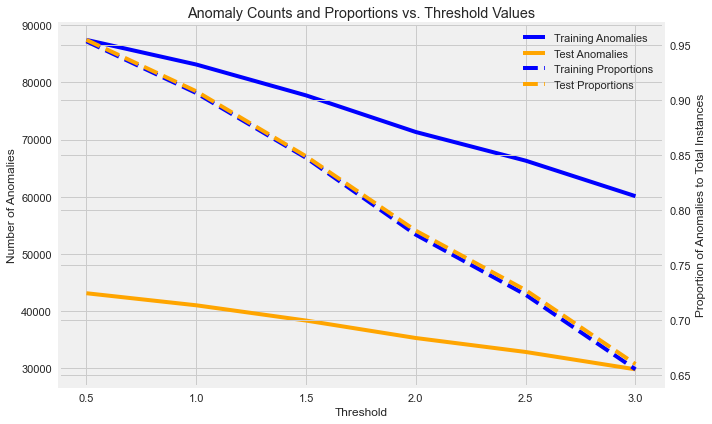

In [25]:
# linear regression model
linear_reg = LinearRegression()
linear_reg.fit(X_train_transformed, y_train)

# predict target values
y_train_pred = linear_reg.predict(X_train_transformed)
y_test_pred = linear_reg.predict(X_test_transformed)

# calculate residuals
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

# range of threshold values to loop through
threshold_values = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]

# lists to store anomaly counts and proportions for training and test sets
train_anomaly_counts = []
train_anomaly_proportions = []
test_anomaly_counts = []
test_anomaly_proportions = []

# calculate the total instances in the training and test sets
total_train_instances = len(y_train)
total_test_instances = len(y_test)

# loop through the threshold values and identify anomalies
for threshold in threshold_values:
    
    train_anomalies = train_residuals.abs() > threshold
    test_anomalies = test_residuals.abs() > threshold
    
    train_anomaly_count = train_anomalies.sum()
    test_anomaly_count = test_anomalies.sum()
    
    train_anomaly_counts.append(train_anomaly_count)
    test_anomaly_counts.append(test_anomaly_count)
    
    train_anomaly_proportion = train_anomaly_count / total_train_instances
    test_anomaly_proportion = test_anomaly_count / total_test_instances
    
    train_anomaly_proportions.append(train_anomaly_proportion)
    test_anomaly_proportions.append(test_anomaly_proportion)

# figure and subplots
fig, ax1 = plt.subplots(figsize=(10, 6))

# anomaly counts on the first y-axis
ax1.plot(threshold_values, train_anomaly_counts, label='Training Anomalies', color='blue')
ax1.plot(threshold_values, test_anomaly_counts, label='Test Anomalies', color='orange')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Number of Anomalies')
ax1.tick_params(axis='y')
ax1.legend(loc='upper left')

#second y-axis for the anomaly proportions
ax2 = ax1.twinx()
ax2.plot(threshold_values, train_anomaly_proportions, label='Training Proportions', linestyle='dashed', color='blue')
ax2.plot(threshold_values, test_anomaly_proportions, label='Test Proportions', linestyle='dashed', color='orange')
ax2.set_ylabel('Proportion of Anomalies to Total Instances')
ax2.tick_params(axis='y')

# legends for both y-axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title('Anomaly Counts and Proportions vs. Threshold Values')
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
# scoring linear regression model
linear_reg = LinearRegression()
linear_reg.fit(X_train_transformed, y_train)

# Predict the target values on the training and test sets
y_train_pred = linear_reg.predict(X_train_transformed)
y_test_pred = linear_reg.predict(X_test_transformed)

# Calculate evaluation metrics for training set
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate evaluation metrics for test set
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the evaluation metrics
print("Training Set:")
print(f"Mean Absolute Error (MAE): {train_mae:.2f}")
print(f"Mean Squared Error (MSE): {train_mse:.2f}")
print(f"R-squared (R2): {train_r2:.2f}")
print("\nTest Set:")
print(f"Mean Absolute Error (MAE): {test_mae:.2f}")
print(f"Mean Squared Error (MSE): {test_mse:.2f}")
print(f"R-squared (R2): {test_r2:.2f}")

Training Set:
Mean Absolute Error (MAE): 11.82
Mean Squared Error (MSE): 23788.91
R-squared (R2): 0.11

Test Set:
Mean Absolute Error (MAE): 14.37
Mean Squared Error (MSE): 104987.27
R-squared (R2): 0.03
